In [1]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load data and check

data = pd.read_csv("cust_cc_hist.csv")
data.head()

,cust_id,age,gender,education,bal,purchases,oneoff_purchases,installments_purchases,purchases_trans,credit_limit,...,perc_full_payment,perc_entertainment_purchase,perc_apparels_purchase,perc_groceries_purchase,perc_restaurant_purchase,perc_utility_purchase,perc_telecom_purchase,perc_supermkt_purchase,perc_offline_purchase,perc_online_purchase
0,7897581567,29,Male,Graduate,470010.66,257000.0,49246.0,207754.0,40,450000.0,...,0.000000,0.05,0.25,0.23,0.02,0.21,0.11,0.13,0.83,0.17
1,7783276944,31,Male,Under-Graduate,960107.13,23834.0,0.0,23834.0,5,1500000.0,...,0.000000,0.14,0.36,0.09,0.05,0.11,0.08,0.17,0.38,0.62
2,7968223875,38,Male,Graduate,120788.82,134236.0,103796.0,30440.0,27,400000.0,...,0.000000,0.08,0.16,0.24,0.18,0.03,0.11,0.20,0.86,0.14
3,7797517338,38,Male,Masters,8744.29,78632.0,18632.0,60000.0,7,750000.0,...,0.666667,0.18,0.06,0.24,0.09,0.07,0.11,0.25,0.70,0.30
4,7861757437,25,Male,Under-Graduate,12339.41,145068.0,0.0,145068.0,20,600000.0,...,0.454545,0.31,0.07,0.14,0.00,0.11,0.17,0.20,0.83,0.17


In [3]:
# Dropping 'cust_id' as its unique and not needed for clusturing

data.drop(['cust_id'], axis=1, inplace=True)

In [4]:
# Checking data columns details

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age                          8000 non-null   int64  
 1   gender                       8000 non-null   object 
 2   education                    8000 non-null   object 
 3   bal                          8000 non-null   float64
 4   purchases                    8000 non-null   float64
 5   oneoff_purchases             8000 non-null   float64
 6   installments_purchases       8000 non-null   float64
 7   purchases_trans              8000 non-null   int64  
 8   credit_limit                 7999 non-null   float64
 9   payments                     8000 non-null   float64
 10  min_payments                 7755 non-null   float64
 11  perc_full_payment            8000 non-null   float64
 12  perc_entertainment_purchase  8000 non-null   float64
 13  perc_apparels_purc

In [5]:
# Replacing string in 'gender' and 'education' with integer values

data['gender'].replace(['Male','Female'],[1,2],inplace=True)
data['education'].replace(['Under-Graduate','Graduate','Masters'],[1,2,3],inplace=True)
data.head()

,age,gender,education,bal,purchases,oneoff_purchases,installments_purchases,purchases_trans,credit_limit,payments,...,perc_full_payment,perc_entertainment_purchase,perc_apparels_purchase,perc_groceries_purchase,perc_restaurant_purchase,perc_utility_purchase,perc_telecom_purchase,perc_supermkt_purchase,perc_offline_purchase,perc_online_purchase
0,29,1,2,470010.66,257000.0,49246.0,207754.0,40,450000.0,325995.83,...,0.000000,0.05,0.25,0.23,0.02,0.21,0.11,0.13,0.83,0.17
1,31,1,1,960107.13,23834.0,0.0,23834.0,5,1500000.0,119451.08,...,0.000000,0.14,0.36,0.09,0.05,0.11,0.08,0.17,0.38,0.62
2,38,1,2,120788.82,134236.0,103796.0,30440.0,27,400000.0,28888.30,...,0.000000,0.08,0.16,0.24,0.18,0.03,0.11,0.20,0.86,0.14
3,38,1,3,8744.29,78632.0,18632.0,60000.0,7,750000.0,88128.46,...,0.666667,0.18,0.06,0.24,0.09,0.07,0.11,0.25,0.70,0.30
4,25,1,1,12339.41,145068.0,0.0,145068.0,20,600000.0,158342.19,...,0.454545,0.31,0.07,0.14,0.00,0.11,0.17,0.20,0.83,0.17


In [6]:
# Checking data columns details

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age                          8000 non-null   int64  
 1   gender                       8000 non-null   int64  
 2   education                    8000 non-null   int64  
 3   bal                          8000 non-null   float64
 4   purchases                    8000 non-null   float64
 5   oneoff_purchases             8000 non-null   float64
 6   installments_purchases       8000 non-null   float64
 7   purchases_trans              8000 non-null   int64  
 8   credit_limit                 7999 non-null   float64
 9   payments                     8000 non-null   float64
 10  min_payments                 7755 non-null   float64
 11  perc_full_payment            8000 non-null   float64
 12  perc_entertainment_purchase  8000 non-null   float64
 13  perc_apparels_purc

In [7]:
# Checking missing data

missing_data = data.isna().sum()
print(missing_data)

age                              0
gender                           0
education                        0
bal                              0
purchases                        0
oneoff_purchases                 0
installments_purchases           0
purchases_trans                  0
credit_limit                     1
payments                         0
min_payments                   245
perc_full_payment                0
perc_entertainment_purchase      0
perc_apparels_purchase           0
perc_groceries_purchase          0
perc_restaurant_purchase         0
perc_utility_purchase            0
perc_telecom_purchase            0
perc_supermkt_purchase           0
perc_offline_purchase            0
perc_online_purchase             0
dtype: int64


In [8]:
# Only 1 missing data for 'credit_limit'. Dropping the row

data.drop(['credit_limit'], axis=1, inplace=True)

# Filling median for rest of the missing data (min_payments)

data = data.fillna(data.median())

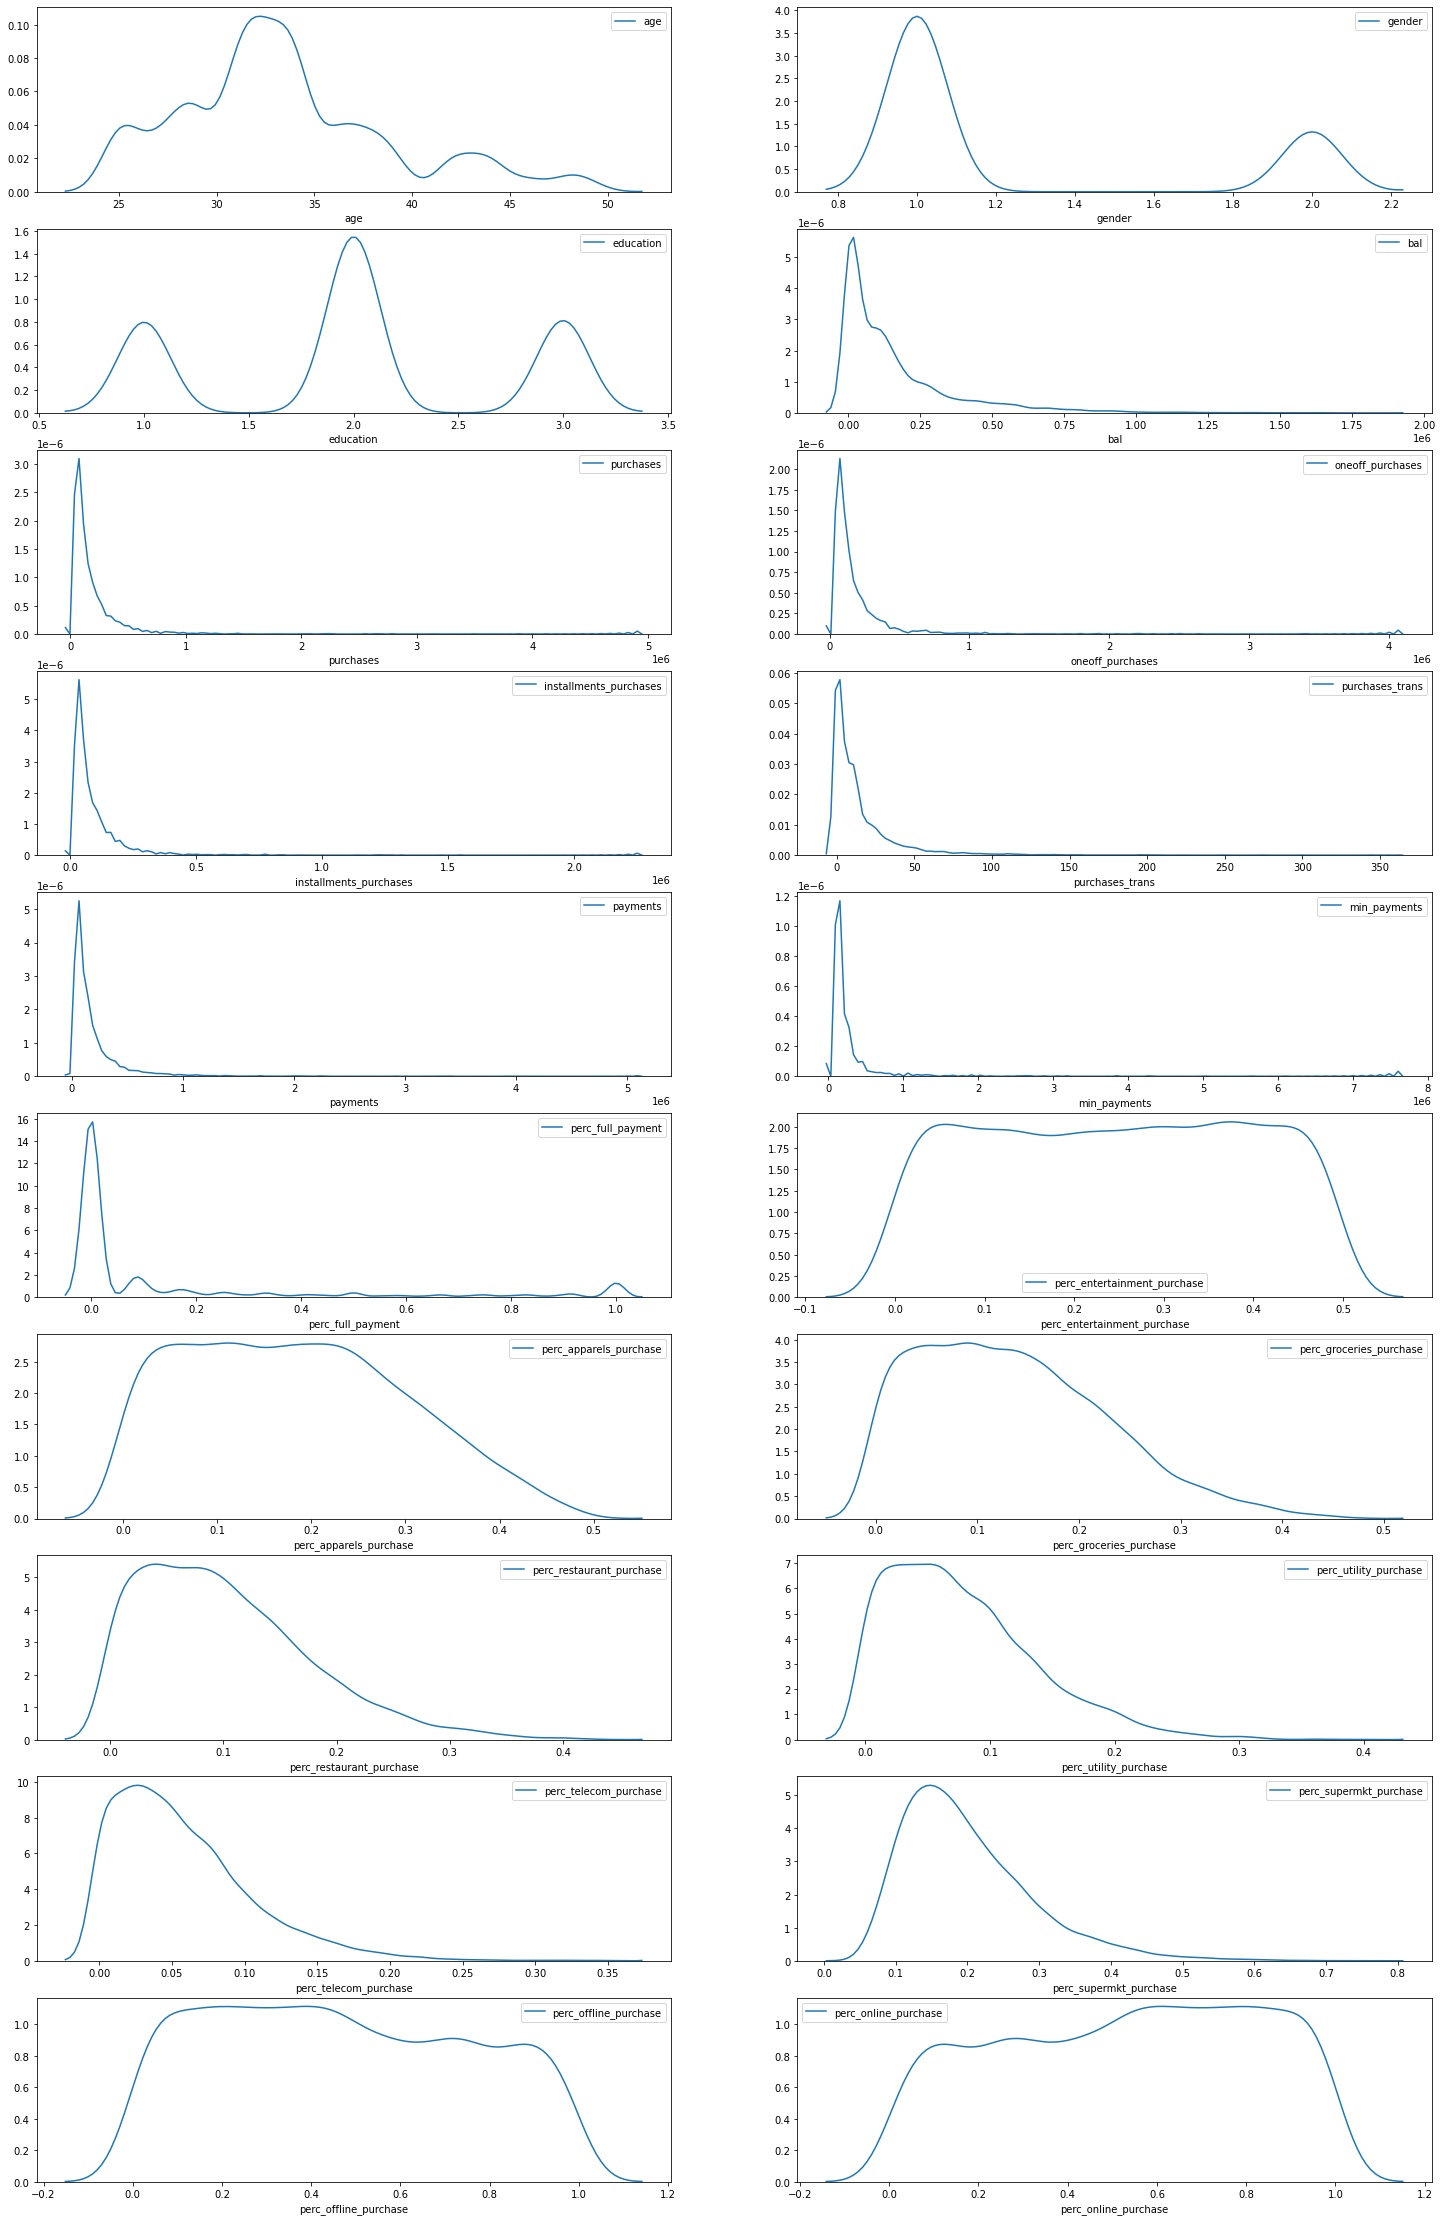

In [9]:
# Plotting skewness

plt.figure(figsize=(25,40))
for i, col in enumerate(data.columns):
    ax = plt.subplot(10, 2, i+1)
    sns.kdeplot(data[col], ax=ax)
    plt.xlabel(col)
        
plt.show()

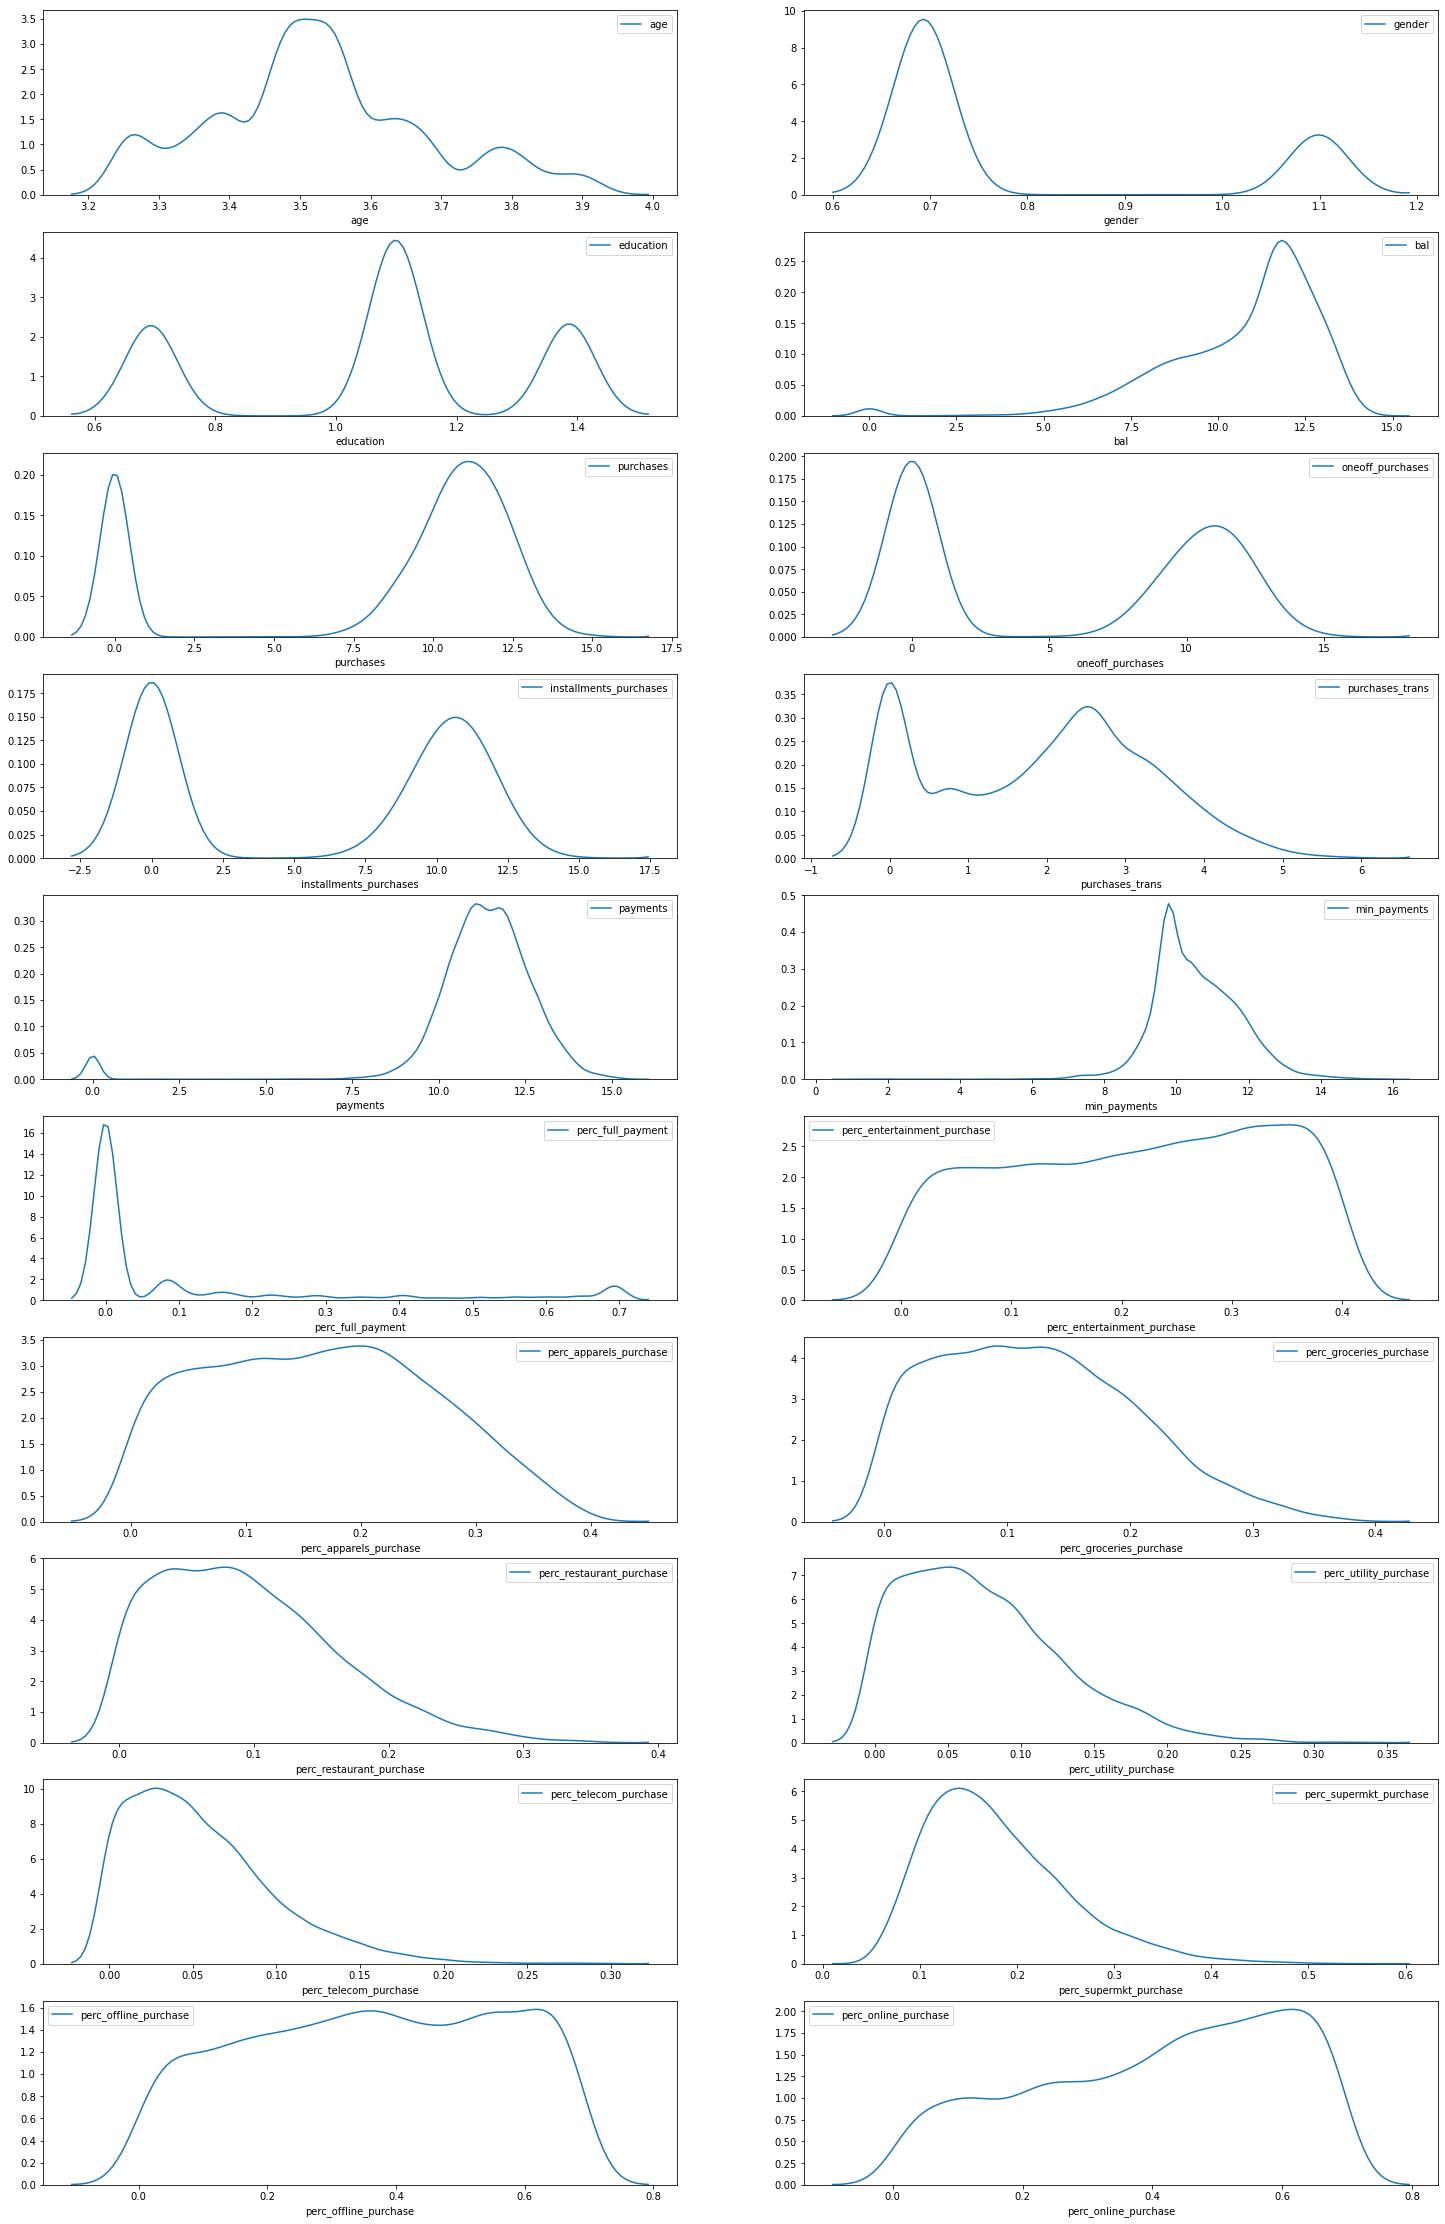

In [10]:
# Handling skewness

cols = ['age', 'gender', 'education', 'bal', 'purchases', 'oneoff_purchases', 'installments_purchases', 'purchases_trans', 
        'payments', 'min_payments', 'perc_full_payment', 'perc_entertainment_purchase', 'perc_apparels_purchase', 
        'perc_groceries_purchase', 'perc_restaurant_purchase', 'perc_utility_purchase', 'perc_telecom_purchase', 
        'perc_supermkt_purchase', 'perc_offline_purchase', 'perc_online_purchase']

for col in cols:
    data[col] = np.log(1 + data[col])

plt.figure(figsize=(25,40))
for i, col in enumerate(data.columns):
    ax = plt.subplot(10, 2, i+1)
    sns.kdeplot(data[col], ax=ax)
    plt.xlabel(col)

plt.show()

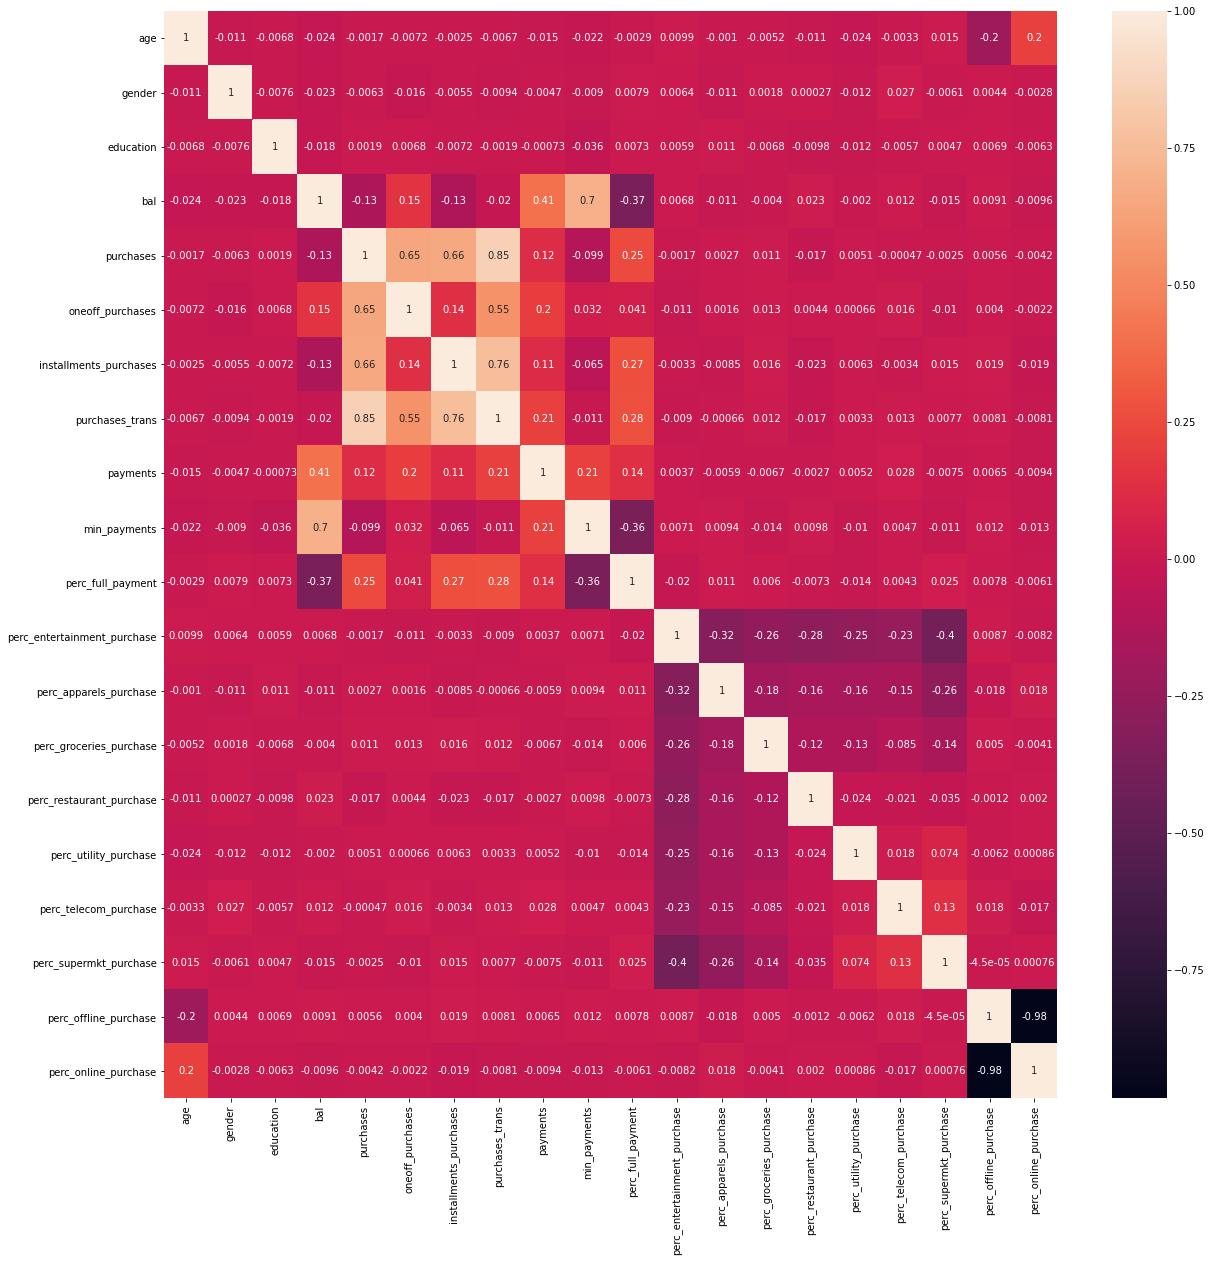

In [11]:
plt.figure(figsize=(20,20))
sns.heatmap(data.corr(), annot=True)
plt.show()

In [12]:
# Applying PCA

from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
vals = pca.fit_transform(data)

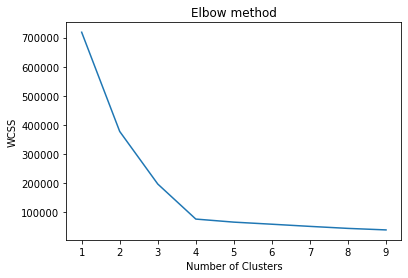

In [13]:
# Use the Elbow method to find a good number of clusters using WCSS

from sklearn.cluster import KMeans

kmeans_models = [KMeans(n_clusters=k, random_state=23).fit(vals) for k in range (1, 10)]
innertia = [model.inertia_ for model in kmeans_models]

plt.plot(range(1, 10), innertia)
plt.title('Elbow method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [14]:
# Elbow is at 4. Checking silhouette score

from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=4, random_state=23)
kmeans.fit(vals)

print('Silhoutte score of our model is ' + str(silhouette_score(vals, kmeans.labels_)))

Silhoutte score of our model is 0.7055955840758381


In [15]:
# Inverse transforming the log transformation

data['cluster_id'] = kmeans.labels_

for col in data.columns:
    data[col] = np.exp(data[col])

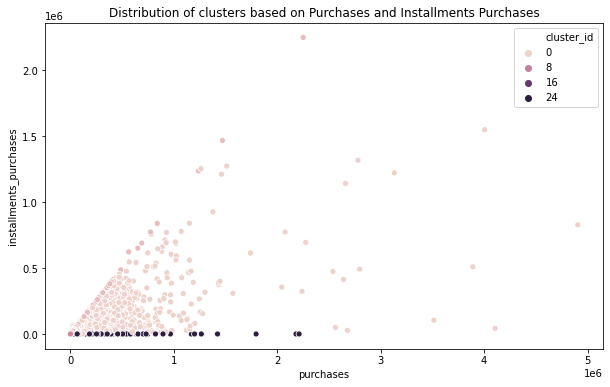

In [16]:
# Plotting clusters based on Purchases and Installments Purchases

plt.figure(figsize=(10,6))
sns.scatterplot(data=data, x='purchases', y='installments_purchases', hue='cluster_id')
plt.title('Distribution of clusters based on Purchases and Installments Purchases')
plt.show()

In [17]:
# Next need to understand the customer clusters and behavious.